# HERA Memo: Creating Auto-Correlations with a Generative Adverserial Neural Network 

### Joseph C. Shy, 2021 CHAMP Scholar, 08/13/2021
#### Questions? Contact me: jshy@calpoly.edu or joeyshy883@gmail.com

organize github and include here

define autocorrelation??? need to show an example somewhere before model discussions

## 1. Introduction & Machine Learning Basics

### 1.1. Machine Learning applied to HERA
As the HERA radio antenna array continue to be developed, modified, and built upon, the challenge of identifying working antennas from their broken counterparts becomes a major priority before analysis can be performed with the data received. Currently, the standard for the HERA collaboration is to visually assess auto-correlations that are returned from every observing antenna on a specific night of observation. Each assessment is performed manually by an operator and repeated by a handful of other operators for thoroughness and redundancy. <br><br>
**SHOW EXAMPLE OF BAD AND GOOD AUTOS**<br><br>
This process can prove inconvenient, as it requires a large amount of focused time to gain confidence in the flag given to a certain antenna (the flag states its potential issue or if it is cleared for use). Additionally, it is close to impossible to visually check every auto-correlation that is computed every night (typically > 100,000). Therefore, this leads to the situation where a good auto-correlation from an antenna flagged as broken may be discarded as it was not screened. It is in best interest to preserve as much data from each antenna as possible. <br><br>
Machine learning, and more specifically, a generative adversarial neural network (or GAN), has potential to automate and improve the current system for flagging antennas. The current working networks that will be focused on in the sections below are designed to be able to:
1. Screen every auto-correlation produced.
2. Flag an auto-correlation as `PASS` or `NO PASS` <br>

This system will have the potential to greatly reduce the amount of time required for operators to assess the auto-correlations, instead with their roles being only to classify the issues in the `NO PASS` auto-correlations. Additionally, the ability to screen every auto-correlation should increase the influx of useable data for analysis. <br><br> 
However, full automation of this process could be an opporunity in the future through expanding the scope of the models shown below. Please refer to **fUTRUE WORK**.

### 1.2. Basics of a GAN
A [generative adversarial neural network](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/) is a clever combination of two deep learning architectures. These deep learning architectures are ["computing system(s) made up of a number of simple, highly interconnected processing elements, which process information by their dynamic state response to external inputs" ](https://towardsdatascience.com/a-gentle-introduction-to-neural-networks-series-part-1-2b90b87795bc). The basic learning scheme for a neural network involves inputting a data set with specific flags (or classifiers) associated to each singular piece of data within the set (ie. image or plot) and allowing the processing elements within the neural network to update/learn in order to improve in its ability to classify certain sets of data. Each time a model updates its processing elements (or weights) is called an epoch. The magnitude in which the neural network updates its processing elements (or neurons) is based on the result of the loss at each training epoch. However, this is the most basic application of neural networks, but they can be manipulated to do much more, which will be elaborated upon next.<br><br>
The two learning architectures described within this memo ar refered to as the detector model and the generator model. They general idea is to make the two models compete. The generator's goal is to incrementally improve in its ability to create fake auto-correlations that look real. The detector's goal is to become better at discriminating between real measurements and fake ones. <br><br>
The detector model operates similarly to the basic classification neural network described above; however, the classifications that the detector trains upon are `REAL` and `FAKE`. It receives an input training set of auto-correlations that are deemed good for analysis. Accompanying these input auto-correlations are classfication flags (which are simply integers of 1 arranged in a list the size of the auto-correlation training set) that are used to communicate to the detector model that the incoming input values are `REAL` auto-correlations. Additionally, the detector receives `FAKE` auto-correlations generated from the generator model. At each epoch, the detector will train and improve in its ability to discriminate between `REAL` and `FAKE` auto-correlations. <br><br>
However, the generator model trains as well, learning how to better create `FAKE` auto-correlations that increasingly resemble good auto-correlations. The method in which this occurs is by combining the generator and discriminator model into a larger overarching GAN learning architecture. It is important to note that within the GAN model, the discrimator cannot be trained/updated. The input is a [latent space](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d), which is a set of random numbers vectors returned from the [standard normal distribution](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_probability/bs704_probability9.html). This generator receives this latent space and performs a set of hidden mathematical operations on it, which are derived from the model's architecure and weights. The output of this generator is a `FAKE` auto-correlation, which is subsequently fed into the detector model with a `REAL` classification. This is where the generator training occurs, as the detector will most likely return large losses, as it is being contradictory information contradicting its previous training outside the GAN architecture. The detector model will output a loss value which the generator uses to update its model weights in order to be able to create `FAKE` auto-correlations that will better trick the detector. It is important to note that the contradictory information fed into the detector will not infuence its own training and ability to discriminate between `REAL` and `FAKE` data, as within the GAN model, the detector is restricted from updating its model weights. 

is it overkill to `REAL` and `FAKE` every one of those words

## 2. Data Set Selection 
When training a GAN, the selection of the training set is vital for streamlining time to train and to prevent training failure. With HERA's correlators constantly seeing improvement and modifications, what is seen as a good auto-correlation that validates an antenna's use can vary dependent on the data set. The trend of the measurement over the frequency range and/or the magnitude of the power measured at each frequency may differ between different sets. Additionally, each antenna produces auto-correlations of varying polarizations, which differniate from one another as well. <br><br>
As this study is to serve as a validation of GAN architecture for detecting and producing fake auto-correlations, it is important not to expand our training set to be too large and/or too complex. Showing the GAN auto-correlation sets that are all considered valid but differ signficantly from one another, will most likely result in much longer GAN training times or GAN training failure, as neural networks rely heavily on being able to distinguish overarching features and relationships between multiple auto-correlations in a training set. <br><br>
Therefore, the down-selection to using only validated `"ee"` polarized `H4C` auto-correlations on the observation night of `2459122` is made. This training set is used as a case study in order to learn/create a working GAN architecture that can delineate between real and fake auto-correlations and produce realistic auto-correlations from random input vectors known as latent space. <br><br>
In order to train the GAN on what valid auto-correlations look like, there can only be valid data in the training set. Fortunately, the data mentioned above was chosen as it was previously validated by members of the HERA collaboration and had more successful/valid antenna measurements than other data sets. The bad antennas (which are listed under the list "ex_ants" [here](https://docs.google.com/spreadsheets/d/1xFo2PLVUhXHe-yqHHl0WrRe5pXZF2zC8Z1fLqPZbPZ8/edit#gid=418790055)). 

The auto-correlation data was retrieved from `Lustre` through the filepath `/lustre/aoc/projects/hera/H4C/2459122`. All files within this directory are used, with the good `"ee"` polarized antennas being separated, organized, and saved locally (the code is omitted as it is not the focus of this study). Please use this [reference](https://github.com/HERA-Team/hera_cal/blob/master/scripts/notebooks/io_example.ipynb) if interested how to access `HERAData` files. 

In [1]:
import numpy as np

**NOTE:** 15% of the valid auto-correlations are split into a separate set that will not be used for model training. 75% of this separate set is used as the validation set, that is used to evaluate the model at each epoch. The other 25% is used as the test set, which will be used at to evaluate the models at the end of training.

In [2]:
auto_data_train = np.load('2459122_good_auto-corrs_train.npy') # load-in the auto-correlation data to train on
auto_data_valid = np.load('2459122_good_auto-corrs_valid.npy') # load-in the auto-correlation data to use as for validation
auto_data_test = np.load('2459122_good_auto-corrs_test.npy') # load-in the auto-correlation data to use as for testing
freqs = np.load('HERA_auto-corr_freqs.npy') # load-in frequency channels (from HERA meta-data) [Hz]

Logistical data of the auto-correlation sets can be seen below.

In [3]:
print('# of frequency channels: {}'.format(len(freqs)))
print('# of auto-correlations to train on: {}'.format(len(auto_data_train)))
print('# of auto-correlations to use for validation: {}'.format(len(auto_data_valid)))
print('# of auto-correlations to use for test: {}'.format(len(auto_data_test)))

# of frequency channels: 1536
# of auto-correlations to train on: 142443
# of auto-correlations to use for validation: 18852
# of auto-correlations to use for test: 6285


## 3. Addressing Auto-Correlation Uncertainty

### 3.1. The Radiometer Equation
Theoretically, two auto-correlations retrieved from two consecutive integrations from the same radio antenna should return identical auto-correlations, as it is a measurement from nearly identical patches of the sky. However, in practice, these auto-correlations will never be identical due to the [noise](https://casper.ssl.berkeley.edu/astrobaki/index.php/Noise_Temperature) introduced by certain measurement devices (ie. receivers or amplifiers). 

The expected noise distribution for the measurment can be understood with the [Radiometer Equation](https://casper.ssl.berkeley.edu/astrobaki/index.php/Radiometer_Equation) This equation quantifies the noise introduced by the measuring equipment from known properties of the measuring devices and experiment. 

<center> $\sigma_{T} = \frac{T_{sky}}{\sqrt{BW*t}}$ <center>

*T<sub>sky</sub>* is the actual "sky temperature" or power that should be measured in an ideal auto-correlation (without losses or noise). *BW* is the integrated bandwidth of the auto-correlation. The integration time, *t*, (or the time in which the measurement is averaged from multiple shorter exposures). These values, when applied with the equation above, produce *σ<sub>T</sub>*, which is the residual uncertainty in a sky temperature measurement.

### 3.2. Application to GAN Learning
Due to this random noise introduced by the measuring equipment, every auto-correlation in the training set is unique from one another. To the GAN, this uniqueness is seemingly random at surface level, as the neural networks only have access to the raw measurements within the training set. Therefore, the generator would not only have to learn the recurring auto-correlation trends and RFI channel patterns, but it would also be forced to learn how to produce fake auto-correlations with random noise. This proved to be a difficult task for the generator early in model development, as a realisic fake auto-correlation could not be produced even after 10,000 epochs (or iterations in which the GAN weights are updated and the model "learns"). <br> <br>
Therefore, in order to assist the generator in training and shorten the training duration, the noise quantified by the Radiometer Equation was implemented into the models and training function. The motivation behind the use of a noise model is to relieve some of the features the generator is required to learn (ie. radiometer noise) and instead allow it to focus on learning idealized auto-correlation patterns. <br><br>
The generator produces some power, or *T<sub>sky</sub>* at each frequency channel. Anytime the the generated (fake) measurement is input into or used to train the detector, a multiplicative random noise factor is applied to the sky temperature at each frequeny. This noise factor is random value drawn from a 1-centered gaussian distribution with a standard deviation drawn from the Radiometer Equation.

<center> $stddev = \frac{1}{\sqrt{BW*t}}$ <center>

The process of calculating this standard deviation for an `H4C` auto-correlation on the night of `2459122` is shown below. 

In [4]:
from hera_cal.io import HERAData # HERAData required for reading in '.uvh5' files

In [5]:
# load-in random file from designated directory for training data retrieval 
# NOTE: abritrary file is used, as only its meta-data is of interest (which remains the same for all H4C data)

hd = HERAData('/lustre/aoc/projects/hera/H4C/2459122/zen.2459122.25108.sum.autos.uvh5') # load-in file
meta = hd.get_metadata_dict() # get meta-data

BW = np.median(np.diff(meta['freqs'])) # calculate bandwidth [Hz]

int_time = np.median(np.diff(meta['times'])) # calculate integration time [Julian days]
int_time *= 24*3600 # convert Julian data to seconds 

stddev = 1/np.sqrt(BW*int_time) # calculate standard deviation from Radiometer Eqn. [unitless]

In [6]:
print('standard deviation of auto-correlation power = {}'.format(stddev))

standard deviation of auto-correlation power = 0.0009207119165799618


## 4. Model Building 
The neural network models were built through the heavy use of the [Keras API](https://keras.io/api/). Keras is an accessible method of employing [TensorFlow](https://www.tensorflow.org/) for machine-learning tasks. 

Most, if not all, neural network structures are built with the following high-level [components](https://towardsdatascience.com/a-gentle-introduction-to-neural-networks-series-part-1-2b90b87795bc):
1. Input Layer: receives input data set into the model
2. Hidden Layers: intermediate computation is performed and information/weights are transfered to the next layer
3. Output Layer: layer where final activation function occurs and maps to a desired output type
4. Connections/Weights: constantly changing/updating values (during training) that transfer the output of a neuron to the input of a neuron in the next layer
5. Activation Function: defines output of a layer; varies dependent on function type
6. Learning Rule: algorithm that aims to optimize the model training or produce a favored output, usually by modifying weights 

It is important to note that GANs are a relatively new idea being researched in the machine-learning community, with the [first paper](https://arxiv.org/abs/1406.2661) researching adversarial networks being published in 2014. That being said, much of GAN development is motivated by previosuly proven techniques, making many choices in model architecture being made due to ideas that have worked in other machine-learning projects. At times, the chosen [hyperparameters](https://towardsdatascience.com/understanding-hyperparameters-and-its-optimisation-techniques-f0debba07568) are best optimized through trial and error.

A few general standards are adopted from other experts in the machine learning community. These standards are used to prevent a specific failure called [mode collapse](https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/) that was seen in very early preliminary training of these models. The reference to mode collapse above also provides the standards to adopt to help prevent it from occuring. The two main guidelines are to use [`LeakyReLU`](https://keras.io/api/layers/activation_layers/leaky_relu/) activation with a slope of 2 for each hidden layer and to use the [`ADAM`](https://keras.io/api/optimizers/adam/) stochastic gradient descent learning rule with a learning rate of 0.0002 and a momentum of 0.5 as the model optimizer. <br><br>
With these guidelines implemented universally, the GAN learns more quickly and stably than in earlier versions. 

Import the necessary functions/libraries for building a GAN with Keras.

In [7]:
import tensorflow as tf # import the tensflow library - necessary for any machine-learning task
import matplotlib.pyplot as plt # import matplotlib library for plotting purposes
from tensorflow import keras # import keras, the API of tensorflow being used

# import specific layers for model building
from tensorflow.keras.models import Sequential # model type used for detector and generator
from tensorflow.keras.layers import Dense # fully-connected layer
from tensorflow.keras.layers import GaussianNoise # model layer to implement noise to batch input
from tensorflow.keras.layers import LeakyReLU # model layer for the LeakyReLU activation function
from tensorflow.keras.layers import Conv1D # one-dimensional convolutional layer
from tensorflow.keras.layers import Conv1DTranspose # one-dimensional convolutional transpose layer
from tensorflow.keras.layers import Flatten # model layer that flattens input data to one-dimension
from tensorflow.keras.layers import Reshape # model layer that reshapes inpu to desired shape
from tensorflow.keras import activations # layer activation models
from tensorflow.keras.optimizers import Adam # "Adam" optimization algorithm for model compililation
from tensorflow.keras.layers import AveragePooling1D # average pooling layer
from tensorflow.keras.layers import Multiply, Add # used to multiply or add outputs of multiple layers (cannot be used in a sequential model)

from tensorflow.keras.utils import plot_model # plots sequentially-layered structure of NN models for visualization

from datetime import datetime # datetime module to get current time 

# jupyter notebook specific command to show plots inline with notebook
%matplotlib inline 

**future work batch norm and dropout**

### 4.1. Inputs Required to Build a Model

In order to build a model with Keras, a couple inputs must be understood. 

One input is the `batch size`, which is the number of training examples the model trains with in one epoch. The batch size is left as a constant 512, regardless of detector or GAN training. It is standard practice in much of machine learning to keep the batch size as a power of 2. Typically batch sizes are lower than the one being implemented here in order to prevent [overfitting](https://elitedatascience.com/overfitting-in-machine-learning) of the detector or generator model. But the choice to keep the batch size a little larger than standard was made due to the large size of the H4C training set, which consists of all unique measurements, allowing overfitting to be less likely. 

The other other input is the `input shape` of a single example in the batch that is to be sent to the input layer of the neural network. 

### 4.2. The Detector Model
The detector model is built [sequentially](https://keras.io/guides/sequential_model/), meaning that each layer is stacked atop one another. Therefore, there is only one input tensor and output tensor for each layer, and the output of a layer above is the input to the layer below. 

The detector model is built with an initial three convolutional layer blocks (with a built-in input layer within the first block), three subsequent fully-connected layers (or [`Dense`](https://keras.io/api/layers/core_layers/dense/) layers), and a final fully-connected layer that outputs that serves as th output layer. 

The convolutional layers are one-dimensional ([`Conv1D`](https://keras.io/api/layers/convolution_layers/convolution1d/)) hidden layers. The purpose of these [convolutional layers](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) are to extract features from the auto-correlation plots. The initial convolutional layers are meant ot extract low-level features, such as minute changes in slope throughout the frequency channels of the auto-correlation. The later layers are meant to detect higher-level features, such as common peaks and troughs in the auto-correlation plots. Combining these layers together allow the detector to have a complete knowledge of what `REAL` and `FAKE` auto-correlations should look like on any scale. The differences between these layers are the number of `filters/features` that it can detect per pixel (or frequency channel in the case of auto-correlations) and the `kernel size`. Kernel size represents the number of adjacent pixels that contribute to the output value of a feature. The larger the kernel size, means the more information that contributes to a detected feature. This is why larger kernel sizes are associated to higher-level features. It is [standard practice](https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7) in convolutional networks to increase in feature numbers and kernel size the deeper the convolutional neural network develops. Other parameters of the convolutional layers include `strides` and `padding`. Padding is assigned as "same" in order to preserve and account for end conditions of the auto-correlations, as they include equally important information to highlighting the validity of an auto-correlation. Other padding methods do not take end conditions well into account for use in convolutional layers. Lastly, the stride size is left as 1. [Stride size](https://deepai.org/machine-learning-glossary-and-terms/stride) is the amount of pixels (or frequency channels) that the kernel moves whe detecting features. It is a form of compression of the input data set. 

The stride size is left as 1 due to the use of external [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/). Pooling, for use after convolutional layers, is a form of down-sampling the feature map output from the convolutional layers to a lower-resolution version that still contains the important features that is used to identify the object (or auto-correlation in this case). Downsampling is a method to prevent overfitting by delocalizing common features, allowing the detector to learn to search for a feature in a region of channels rather than a singular one. This will help the detector when it sees auto-correlations that it has not been exposed to in training. The `stride` parameter is the factor at which the input is down-sampled by. Two common options of pooling are Average Pooling (calculates average of a patch to be down-sampled)  or Maximum Pooling (uses the maximum value from a patch to be down-sampled). `AveragePooling1D` is used over `MaxPooling1D` as it has been [seen in the machine-learning community](https://github.com/soumith/ganhacks) to yield more stable and convergent GAN training results. `Padding` is left as "same" for the same reason as mentioned previously. Also, staggering the pooling layers to occur after every 2-3 convolutional layers has seen [success](https://stackoverflow.com/questions/47128782/when-to-insert-pooling-layer-between-convolution-layers) by others when building convolutional neural networks. Additionally, pooling at every layer would compress the feature map too much, causing less dependeable results from the deeper layers (as they would be fed extremely compressed images).

The `Dense` layers that follow are not standard of a typical convolutional neural network detector model in a GAN. However, research proved that a combination of fully-connected and convolutional layers can result in quicker and more stable GAN training. The paper referencing this claim can be found [here](https://arxiv.org/pdf/1905.02417.pdf). As per the referenced research articles, three intermediate fully-connected layers following the convolutional layers should be implemented. On a high-level, these fully-connected layers can be described to operate by performing various matrix-multiplications on all the ouput from the previous layer. These computational matrices update over time, as they are the weights that are trained with the GAN. The number of `output neurons` from the layer is specified during model building. That specification determines the number of matrices being created and updated through model training. 

The `Flatten` layer is a utility used to flatten the two-dimensional output from the convolutional layers (down-sampled auto-correlation, feature map). This is done in order to preserve all the data from the convolutional layers, as the subsequent `Dense` layers only process the last dimension of its input tensor. All the data included in output tensor from the convolutional layers are important and must be carried through to the end of the model, so flattening is a necessity.

The last layer (or output layer) is a `Dense` layer with an output neuron of 1. It uses the [`Sigmoid`](https://keras.io/api/layers/activations/) activation function, as it can only produce values between 0 and 1. Recall that the purpose of the detector is to be a binary classifier (or classify between one classfication or another). The classification are `REAL` or `FAKE`. These flags are converted to `1` and `0`, respectively, in order for the neural networks to intepret them. Therefore, the detector only is required to output values between 0 and 1. Therefore, sigmoid activation is used. **future work**

#### 4.2.1. Compiling the Detector Model
[`Binary Cross-Entropy`](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) is used as the loss function for the detector. This loss function is used, as the purpose of the detector is to discriminate between two classes (`REAL` or `FAKE`/0 or 1).

The `ADAM` optimizer with a learning rate of 0.0002 and momentum of 0.5 is used per reasoning given in the introduction of **section4**. 

**more on accuracy**

In [8]:
def define_detector(n_inputs,batch_size):
    """
    Build a detector NN that detects if a one-dimensional dataset at a explicit linearly 
    spaced channels (x-axis) is a "real" or "fake" dataset based upon a training. Designed 
    specifically for HERA auto-correlations
    
    Arguments
    ---------
    n_inputs : integer
        Number of values in a single one-dimensional dataset
    batch_size : integer 
        Number of datasets fed into detector at each training call
    
    Returns
    -------
    model : tensorflow.python.keras.engine.sequential.Sequential
        Tensorflow keras, compiled, sequentially-layered model
    
    """
    # initialize a sequential neural network
    model = Sequential(
        [
            
            # first convolutional block
            Conv1D(16, 3, padding='same', strides=1,input_shape=(n_inputs,1),batch_size=batch_size), # one-dim. convolutional layer with built-in input layer
            LeakyReLU(alpha=0.2), # LeakyReLU activation function
            Conv1D(16, 3, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=2, padding='same'), # Average Pooling by a stride of 2

            # second convolutional block 
            # notice that features and kernel size increase the deeper into the model
            Conv1D(32, 5, padding='same', strides=1),
            LeakyReLU(alpha=0.2),
            Conv1D(32, 5, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=2, padding='same'),
            
            # third convolutional block
            Conv1D(64, 7, padding='same', strides=1),
            LeakyReLU(alpha=0.2),
            Conv1D(64, 7, padding='same', strides=1), 
            LeakyReLU(alpha=0.2),
            AveragePooling1D(pool_size=4, padding='same'), # stride by 4, in order to reduce number of trainable parameters (allowing less-computational cost)
            
            # flatten in order to allow dense layer to map to all data from convolutions
            Flatten(),
            
            # first dense layer
            Dense(512), 
            LeakyReLU(alpha=0.2),
            
            # second dense layer
            Dense(64),
            LeakyReLU(alpha=0.2),
            
            # third dense layer
            Dense(16),
            LeakyReLU(alpha=0.2),

            # final dense layer with sigmoid activation, allowing the data to be mapped to a 0 or 1 (or somewhere in between) for final classification
            # fake = 0, real = 1, in-between = not a confident decision from the detector
            Dense(1,activation='sigmoid')
                   
        ]
    )
    
    # compile detector model 
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy']) 
    
    # return detector model
    return model

#### 4.2.2. Building and Visualizing the Detector Model
The detector model is to be defined with a batch size of `512` and an input dimension of `1536` (number of frequency channels). It is important to note that the input shape into the detector is (1536,1), in order to be compatible with the shape parameter requirments of the `Conv1D` layers.

In [9]:
# define inputs into define_detector() function
batch_size = 512; # number of data examples input into all model training iterations
n_inputs = 1536 # number of data values in one dataset - specific to HERA data

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (512, 1536, 16)           64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (512, 1536, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (512, 1536, 16)           784       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (512, 1536, 16)           0         
_________________________________________________________________
average_pooling1d (AveragePo (512, 768, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (512, 768, 32)            2592      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (512, 768, 32)            0

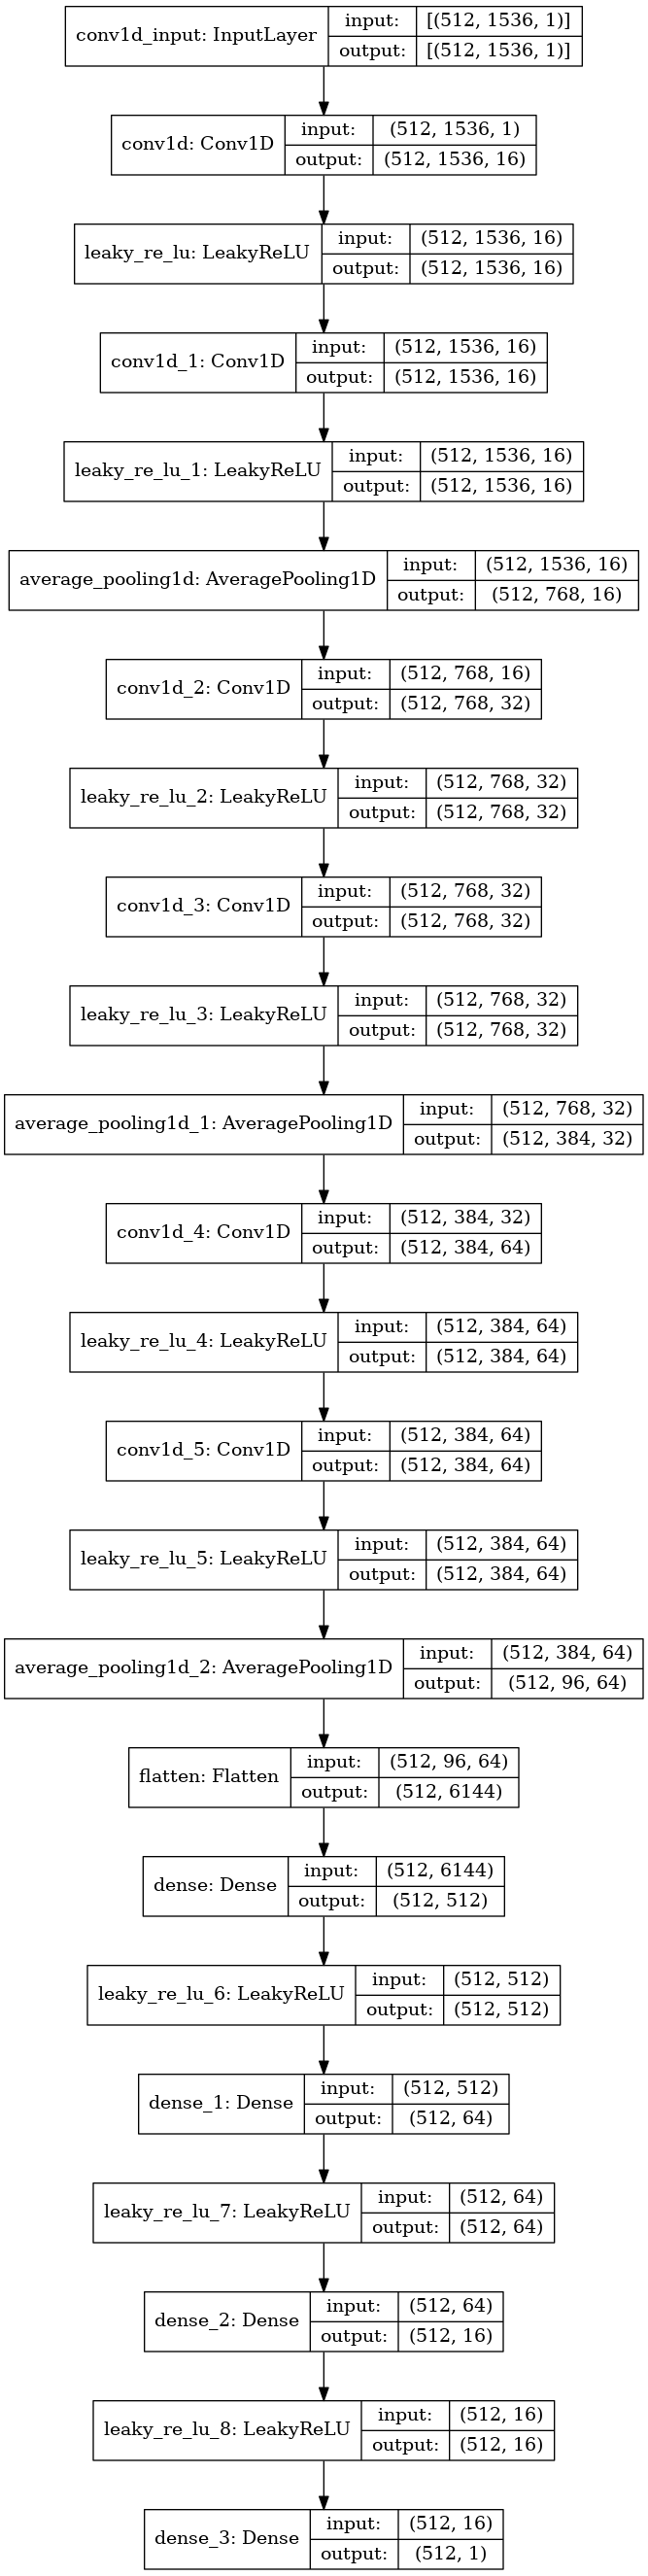

In [11]:
detector = define_detector(n_inputs=n_inputs,batch_size=batch_size)# build detector

# visualize detector architecture
detector.summary()
plot_model(detector, show_shapes=True, show_layer_names=True)

The detector model is now properly compiled, built, and ready for training.

### 4.3 The Generator Model
The generator model is also a sequentially built model, similarly to the detector model. 

In [14]:
def define_generator(n_inputs,latent_dim,batch_size):
    """Build generator NN that produces a fake dataset one-dimensional dataset at explicit linearly-spaced channels (x-axis) in same .  
    
    Arguments:
    n_inputs (int) -- amount of values in a single one-dimensional dataset
    latent_dim (int) -- number of latent dimensions for generator to create a dataset from
    batch_size (int) -- number of datasets fed into detector at each training call
    
    Returns:
    model (tensorflow.python.keras.engine.sequential.Sequential) -- tensorflow keras uncompiled sequentially-layered model 
    
    """
    model = Sequential(
        [
            
            Dense(n_inputs, input_shape=(1,latent_dim),batch_size=batch_size),
            LeakyReLU(alpha=0.2),
            
            Reshape((int(n_inputs/64),64)), 

            Conv1DTranspose(32,5,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(32,5,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            Conv1DTranspose(16,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(16,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            Conv1DTranspose(8,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            Conv1DTranspose(8,3,padding='same',strides=2),
            LeakyReLU(alpha=0.2),
            
            Conv1DTranspose(1,3,padding='same'),
            LeakyReLU(alpha=0.2),
            
            # flatten values to allow for mapping to a single dense layer
            Flatten(),
            
            # map values to a dataset of a desired length, to represent a fake dataset attempting to resemble the real data
            Dense(n_inputs),
            LeakyReLU(alpha=0.2),
            
            # reshape output to be in the format of the detector model input
            Reshape((n_inputs,1))
            
        ]
    )
    return model

#### 4.2.2. Building and Visualizing the Generator Model
The generator model reuses the same batch size as the detector to keep consistency. The input shape into the generator model is the length of the desired latent space to be used within the generator. In this case, it is `22`, which is motivated by a UC Berkley graduate student, Christian Bye (who provided advice and direction for this project). In his own machine-learning project, he used 22 latent dimensions and achieved success, so it was carried over for use in this project. More decisive decision into latent space size and assignment requires much more in-depth analysis and could be an area of **furtherwork** to perfect GAN training. Again, it is important to note that the input shape into the detector is (22,1), in order to be compatible with the shape parameter requirments of the `Conv1D` layers.

In [17]:
latent_dim = 22; # length of desired latent space for input into the generator model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (512, 1, 1536)            35328     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (512, 1, 1536)            0         
_________________________________________________________________
reshape (Reshape)            (512, 24, 64)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (512, 48, 32)             10272     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (512, 48, 32)             0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (512, 96, 32)             5152      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (512, 96, 32)            

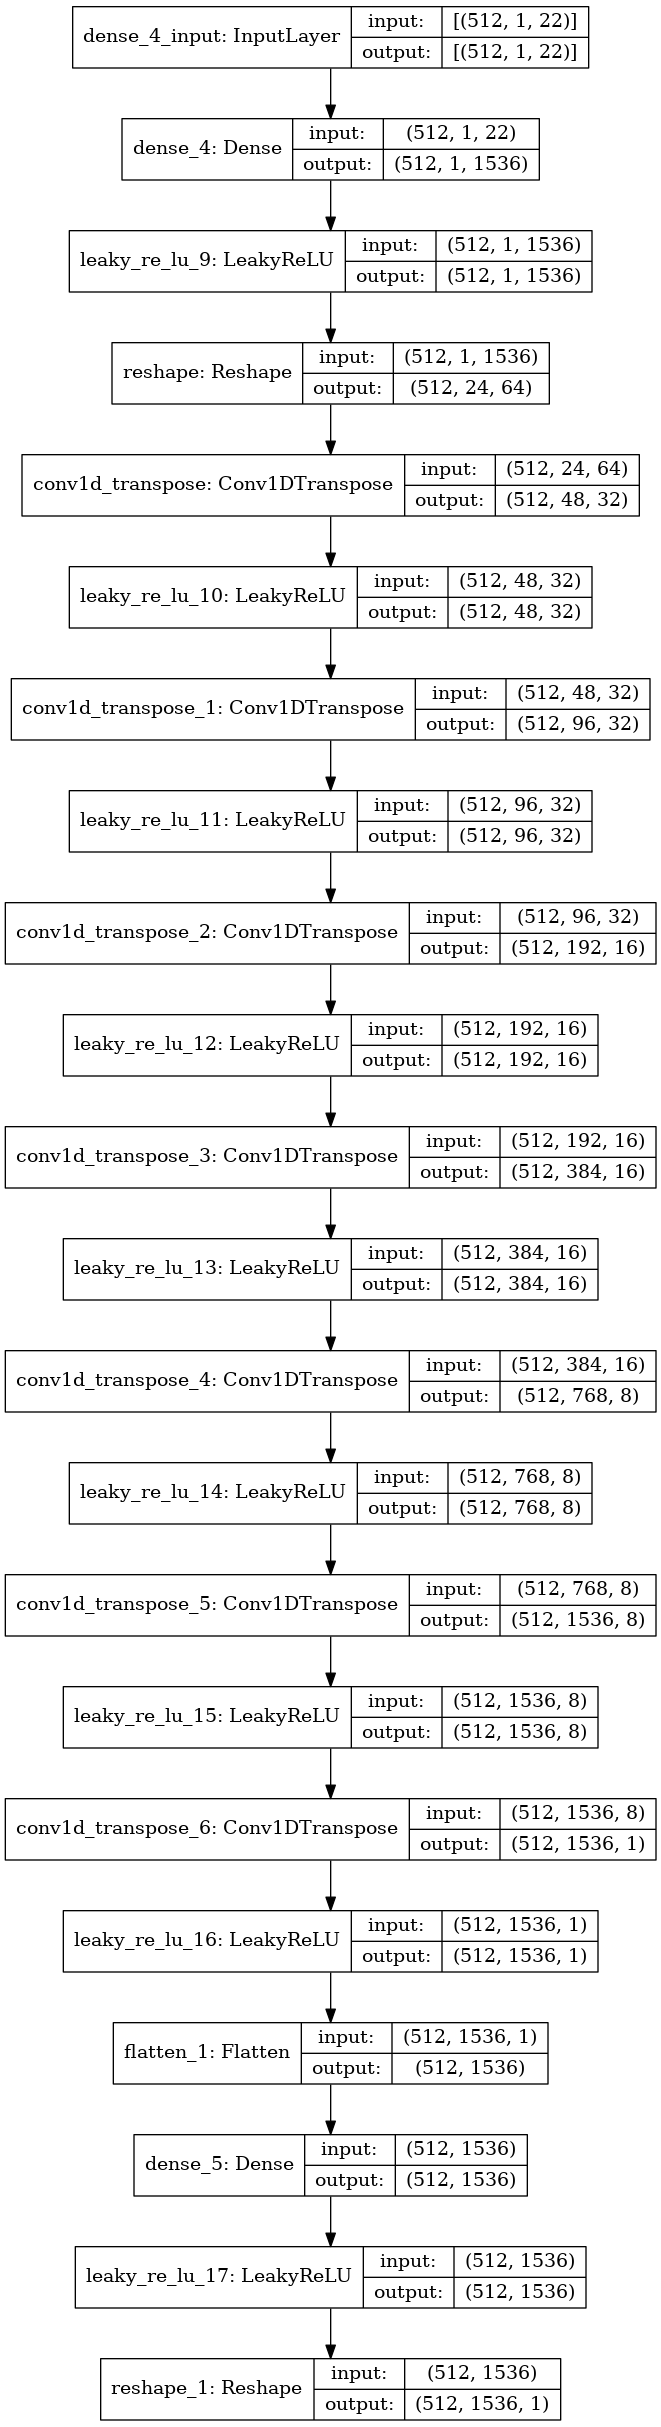

In [18]:
generator = define_generator(n_inputs=n_inputs,latent_dim=latent_dim,batch_size=batch_size) # build generator

# visualize generator architecture
generator.summary() 
plot_model(generator, show_shapes=True, show_layer_names=True)

Future work
- nn
- semi-supervised